In [16]:
import json
import torch
import numpy as np
from transformers import AdamW
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [17]:
file_path = 'qa_dataset.json'

with open(file_path, 'r') as file:
    data = json.load(file)

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [31]:
# Original 
# Prepare data 

# Tokenizing the data
# inputs = tokenizer([x['question'] + " [SEP] " + x['answer'] for x in data], padding=True, truncation=True, return_tensors="pt")

# Assuming binary classification (change as needed)
# labels = torch.tensor([1 if x['answer_length'] > 100 else 0 for x in data])

# Create a dataset
# dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [32]:
# Prepare data

# Tokenizing the data
max_length = max(len(tokenizer.encode(x['question'] + " [SEP] " + x['answer'])) for x in data)
tokenized_data = [tokenizer(x['question'] + " [SEP] " + x['answer'], 
                            padding='max_length',  
                            max_length=max_length,  
                            truncation=True, 
                            return_tensors="pt") for x in data]

# input
input_ids = torch.cat([item['input_ids'] for item in tokenized_data], dim=0)
attention_masks = torch.cat([item['attention_mask'] for item in tokenized_data], dim=0)
labels = torch.tensor([1 if x['answer_length'] > 100 else 0 for x in data])

# dataset seprate
input_ids_train, input_ids_test, attention_masks_train, attention_masks_test, labels_train, labels_test = train_test_split(
    input_ids, attention_masks, labels, train_size=0.7, random_state=42)

# create dataset
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
test_dataset = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# check GPU is work
# Train the model using a suitable optimizer and loss function.
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")

CUDA is available. Using GPU.


In [27]:
print(len(dataset))
dataset[:10]

1628


(tensor([[ 101, 2515, 2023,  ...,    0,    0,    0],
         [ 101, 2064, 2017,  ...,    0,    0,    0],
         [ 101, 2054, 2003,  ...,    0,    0,    0],
         ...,
         [ 101, 2064, 2009,  ...,    0,    0,    0],
         [ 101, 7632, 2515,  ...,    0,    0,    0],
         [ 101, 2003, 1996,  ...,    0,    0,    0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 0]))

In [28]:
# Define a directory to save the model
model_save_path = 'models'
os.makedirs(model_save_path, exist_ok=True)

In [30]:
# Parameters
batch_size = 8
epochs = 25

# Prepare for epoch_losses
epoch_losses = []

# Create dataloader
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")

    for batch in progress_bar:
        # b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Update the progress bar
        progress_bar.set_postfix({'loss': total_loss/len(train_dataloader)})
        
    # Calculate and store the average loss for this epoch
    avg_loss = total_loss / len(train_dataloader)
    epoch_losses.append(avg_loss)
    
    # Save the model after each epoch
    # model_save_file = os.path.join(model_save_path, f'bert_model_epoch_{epoch+1}.pt')
    # torch.save(model.state_dict(), model_save_file)

    # Closing the progress bar and printing the epoch loss
    progress_bar.close()
    print(f"Epoch {epoch+1} finished. Loss: {total_loss/len(train_dataloader)}")


Epoch 1:  32%|███▏      | 46/143 [05:55<12:30,  7.73s/it, loss=0.164] 


KeyboardInterrupt: 

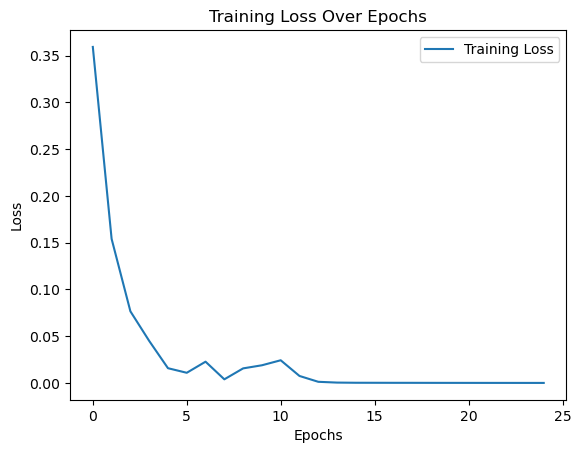

In [12]:
# Plotting the training loss
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

### Evulation 

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Switch to evaluation mode
model.eval()

predictions, true_labels = [], []

# Add tqdm progress bar
for batch in tqdm(test_dataloader, desc="Evaluating"):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    predictions.extend(batch_preds)
    true_labels.extend(label_ids)

# Calculate the accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy}")


Evaluating: 100%|██████████| 204/204 [00:16<00:00, 12.71it/s]

Accuracy: 1.0


### Test for QA